In [35]:
# Install required libraries if not already installed
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, roc_auc_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
# Ensure directories exist
MODEL_SAV_DIR = "./models"
PLOTS_DIR = "./plots"
os.makedirs(MODEL_SAV_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# Define hyperparameters and constants
RANDOM_SEED = 42
DIM_ENCODER = 32
OPTIMIZER = 'adam'
LOSS = 'mse'
EVAL_METRIC = 'mae'
EPOCHS = 50
BATCH_SIZE = 128


In [12]:
# Load dataset
data = pd.read_csv('creditcard.csv')

# Function to preprocess data
def preprocess_data(data):
    data = data.drop(['Time'], axis=1)
    data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
    return data

# Apply preprocessing
data = preprocess_data(data)

# Display first few rows
data.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [36]:
# Separate features and target
X = data.drop('Class', axis=1).values
y = data['Class'].values

# Standard scaling has been done already. Now apply PCA:
# We'll keep enough components to explain 95% of the variance.
pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)
print("Original number of features:", X.shape[1])
print("Reduced number of features after PCA:", X_pca.shape[1])


Original number of features: 29
Reduced number of features after PCA: 23


In [37]:
# Split PCA-transformed data into train and test sets.
X_train_full, X_test, y_train_full, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=RANDOM_SEED)

# For training autoencoder, use only normal transactions.
X_train = X_train_full[y_train_full == 0]
print("Training data shape (normal transactions):", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape (normal transactions): (227451, 23)
Testing data shape: (56962, 23)


In [38]:
def define_autoencoder(input_dim):
    layer_input = Input(shape=(input_dim,))
    # Encoder
    layer_encoder = Dense(DIM_ENCODER, activation="tanh",
                          activity_regularizer=regularizers.l1(10e-5))(layer_input)
    layer_encoder = Dense(int(DIM_ENCODER / 2), activation="relu")(layer_encoder)
    # Decoder
    layer_decoder = Dense(int(DIM_ENCODER / 2), activation="tanh")(layer_encoder)
    layer_decoder = Dense(input_dim, activation="relu")(layer_decoder)
    autoencoder = Model(inputs=layer_input, outputs=layer_decoder)
    return autoencoder

input_dim = X_train.shape[1]
autoencoder = define_autoencoder(input_dim)
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 23)             │           391 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,959 (7.65 KB)

 Trainable params: 1,959 (7.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1776/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1078 - mae: 0.6272
Epoch 1: val_loss improved from inf to 0.79285, saving model to ./models\trained_model.keras
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.1076 - mae: 0.6271 - val_loss: 0.7928 - val_mae: 0.5234
Epoch 2/50
1748/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7379 - mae: 0.5123
Epoch 2: val_loss improved from 0.79285 to 0.73381, saving model to ./models\trained_model.keras
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7377 - mae: 0.5121 - val_loss: 0.7338 - val_mae: 0.4936
Epoch 3/50
1760/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7108 - mae: 0.4870
Epoch 3: val_loss improved from 0.73381 to 0.71686, saving model to ./models\trained_model.keras
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7106 - mae: 0.4870 - val_loss: 0.7169 - val_mae: 0.4815
Epoch 4/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6830 - mae: 0.4767
Epoch 4: val_loss improved from 0.71686 to 0.70910, sa

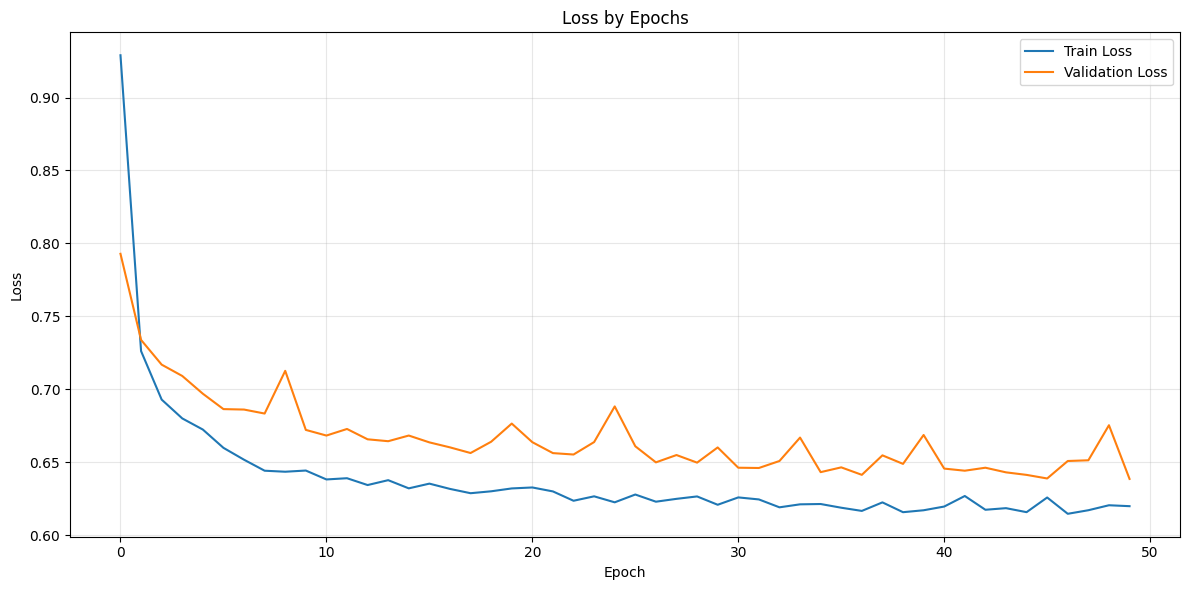

In [39]:
# Compile the autoencoder
autoencoder.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[EVAL_METRIC])

# Define callbacks
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_SAV_DIR, "trained_model.keras"),
                             verbose=1, save_best_only=True)
log_tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

# Train the autoencoder (training only on normal transactions)
history = autoencoder.fit(X_train, X_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          validation_data=(X_test, X_test),  # Validation on all data
                          verbose=1,
                          callbacks=[checkpoint, log_tensorboard])

# Plot and save the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss by Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
loss_plot_path = os.path.join(PLOTS_DIR, "Loss_Curves.png")
plt.savefig(loss_plot_path, dpi=300)
plt.show()


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Best Threshold = 35.1301
Best F1-Score = 0.3571
Precision = 0.5952
Recall = 0.2551
Confusion Matrix:
 [[56847    17]
 [   74    24]]
ROC-AUC Score: 0.6222995001320731
F1 Score: 0.34532374100719426


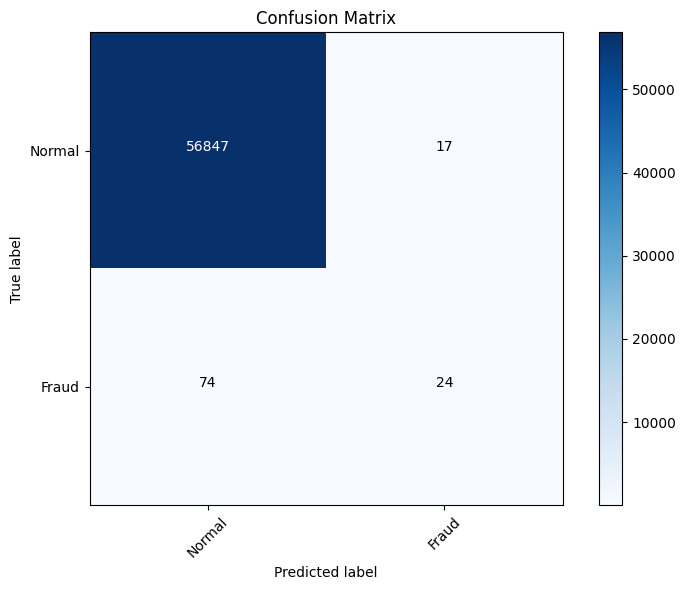

In [40]:
# Get autoencoder predictions on the test set
test_predictions = autoencoder.predict(X_test)
# Compute reconstruction error (MSE) for each sample
mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

# Use precision-recall curve to help choose a threshold
precision, recall, thresholds = precision_recall_curve(y_test, mse)
# Calculate F1 scores for each threshold (avoiding division by zero)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold = {best_threshold:.4f}")
print(f"Best F1-Score = {f1_scores[best_idx]:.4f}")
print(f"Precision = {precision[best_idx]:.4f}")
print(f"Recall = {recall[best_idx]:.4f}")

# Classify transactions based on reconstruction error threshold
predicted_classes = [1 if e > best_threshold else 0 for e in mse]

# Evaluate performance
cnf_matrix = confusion_matrix(y_test, predicted_classes)
auc_score = roc_auc_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

print("Confusion Matrix:\n", cnf_matrix)
print("ROC-AUC Score:", auc_score)
print("F1 Score:", f1)

# Plot the confusion matrix
import itertools

plt.figure(figsize=(8, 6))
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = ['Normal', 'Fraud']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Save the confusion matrix plot
conf_plot_path = os.path.join(PLOTS_DIR, f"Confusion_Matrix_thresh_{best_threshold:.4f}.png")
plt.savefig(conf_plot_path, dpi=300)
plt.show()


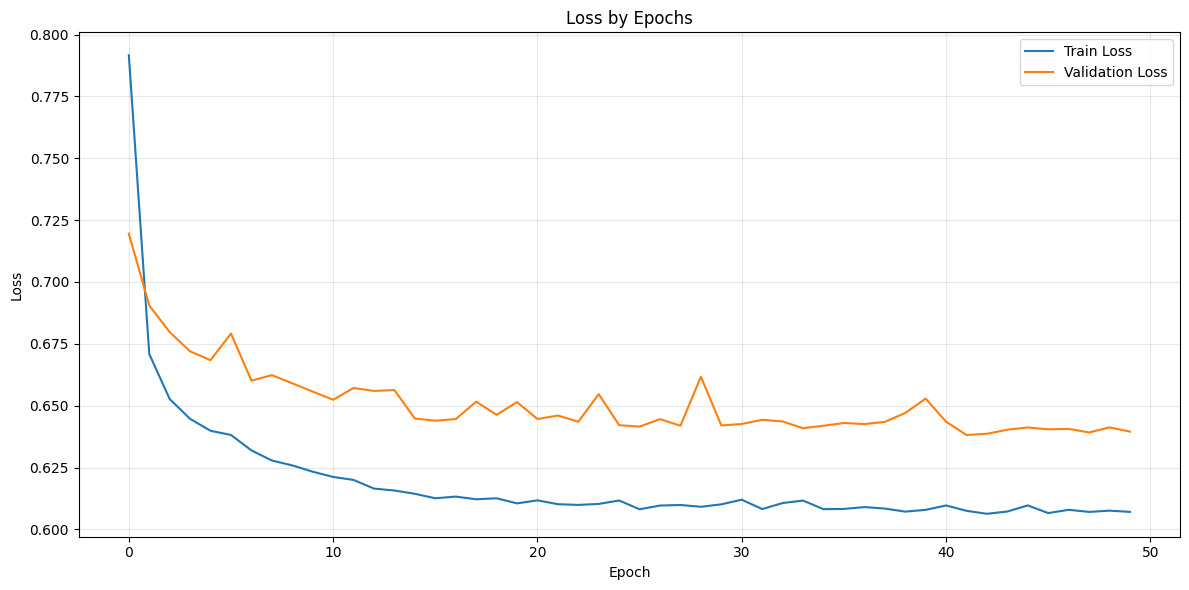

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss by Epochs')
plt.xlabel('Epoch')A
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
loss_plot_path = os.path.join(PLOTS_DIR, "Loss_Curves.png")
plt.savefig(loss_plot_path, dpi=300)
plt.show()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


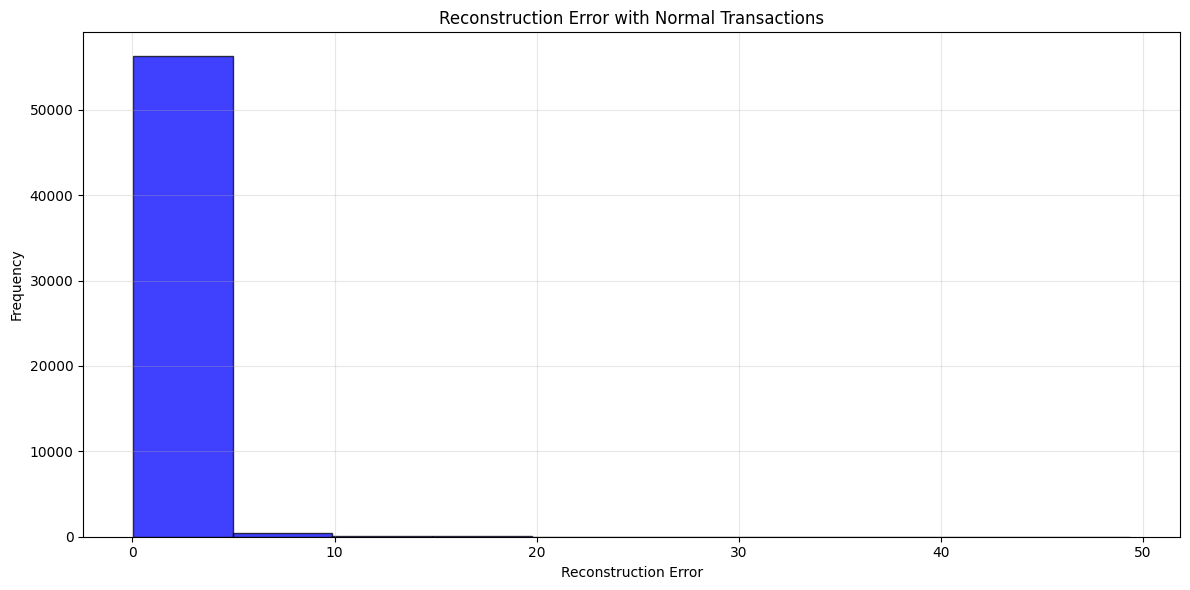

In [27]:
# Function to plot reconstruction error by class
def plot_reconstruction_error_by_class(X_test, y_test, model):
    # Get predictions
    test_predictions = model.predict(X_test)

    # Compute Mean Squared Error for each sample
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

    # Create DataFrame
    recon_error_df = pd.DataFrame({'recon_error': mse, 'true_class': y_test})

    # Filter normal transactions
    normal_error_df = recon_error_df[(recon_error_df['true_class'] == 0) & (recon_error_df['recon_error'] < 50)]

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.hist(normal_error_df.recon_error, bins=10, alpha=0.75, color='blue', edgecolor='black')
    plt.title('Reconstruction Error with Normal Transactions')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save plot
    recon_plot_path = os.path.join(PLOTS_DIR, "Recon_error_with_normal_transactions.png")
    plt.savefig(recon_plot_path, dpi=300)
    plt.show()

# Run the function
plot_reconstruction_error_by_class(X_test, y_test, model)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


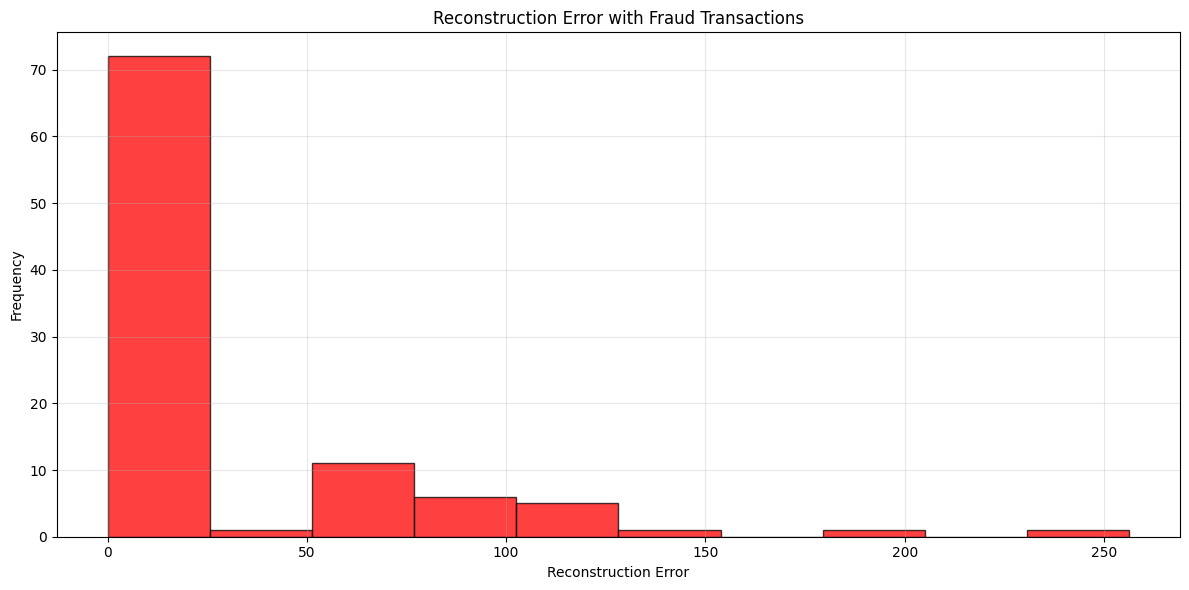

In [28]:
# Function to plot reconstruction error by class for fraud transactions
def plot_reconstruction_error_with_fraud(X_test, y_test, model):
  # Get predictions
  test_predictions = model.predict(X_test)

  # Compute Mean Squared Error for each sample
  mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

  # Create DataFrame
  recon_error_df = pd.DataFrame({'recon_error': mse, 'true_class': y_test})

  # Filter fraud transactions
  fraud_error_df = recon_error_df[recon_error_df['true_class'] == 1]

  # Plot histogram
  plt.figure(figsize=(12, 6))
  plt.hist(fraud_error_df.recon_error, bins=10, alpha=0.75, color='red', edgecolor='black')
  plt.title('Reconstruction Error with Fraud Transactions')
  plt.xlabel('Reconstruction Error')
  plt.ylabel('Frequency')
  plt.grid(True, alpha=0.3)
  plt.tight_layout()

  # Save plot
  fraud_recon_plot_path = os.path.join(PLOTS_DIR, "Recon_error_with_fraud_transactions.png")
  plt.savefig(fraud_recon_plot_path, dpi=300)
  plt.show()

# Run the function
plot_reconstruction_error_with_fraud(X_test, y_test, model)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


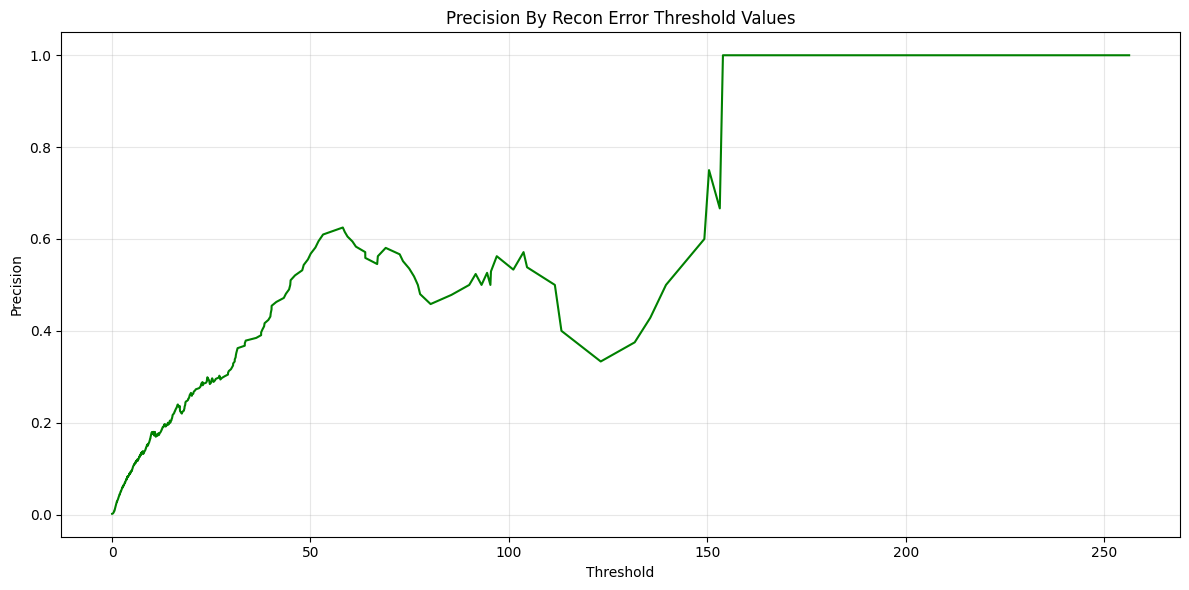

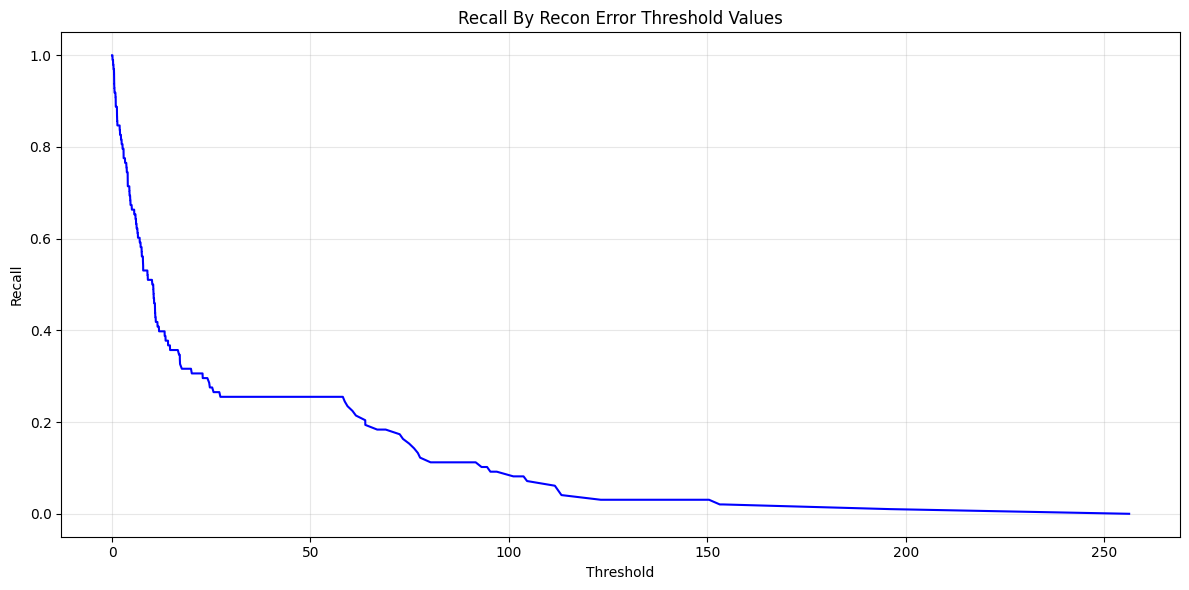

In [32]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def get_precision_recall_curves(X_test, y_test, model):
    # Get predictions
    test_predictions = model.predict(X_test)
    
    # Compute Mean Squared Error for each sample
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
    
    # Create DataFrame
    recon_error_df = pd.DataFrame({'recon_error': mse, 'true_class': y_test})

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(recon_error_df['true_class'], recon_error_df['recon_error'])

    # Plot Precision Curve
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precision[1:], 'g', label='Precision Curve')
    plt.title('Precision By Recon Error Threshold Values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save Precision Curve
    precision_plot_path = os.path.join(PLOTS_DIR, "Precision_Threshold_Curve.png")
    plt.savefig(precision_plot_path, dpi=300)
    plt.show()

    # Plot Recall Curve
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, recall[1:], 'b', label='Recall Curve')
    plt.title('Recall By Recon Error Threshold Values')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save Recall Curve
    recall_plot_path = os.path.join(PLOTS_DIR, "Recall_Threshold_Curve.png")
    plt.savefig(recall_plot_path, dpi=300)
    plt.show()

# Run the function
get_precision_recall_curves(X_test, y_test, model)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Min recall is: 0.8061, Threshold for reconstruction error is: 2.6391


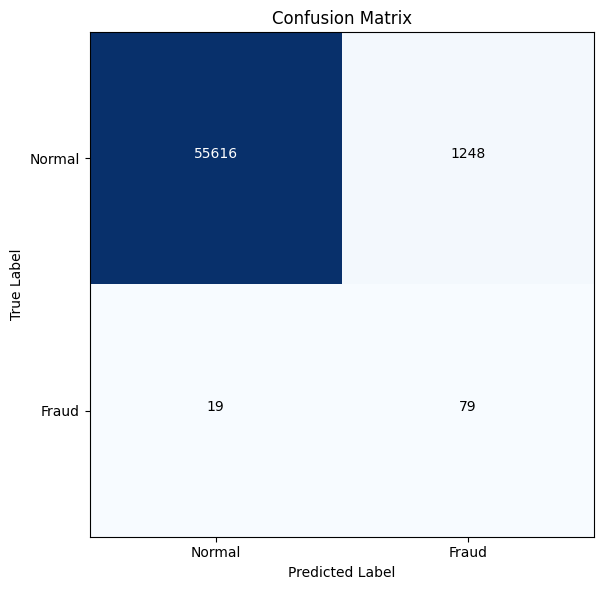

In [33]:
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix

def get_confusion_matrix(X_test, y_test, model, min_recall=0.8):
    # Get predictions
    test_predictions = model.predict(X_test)
    
    # Compute Mean Squared Error (MSE)
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
    
    # Create DataFrame with true class and reconstruction error
    recon_error_df = pd.DataFrame({'recon_error': mse, 'true_class': y_test})

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(recon_error_df['true_class'], recon_error_df['recon_error'])

    # Find the threshold where recall is just above min_recall
    idx = next(i for i, r in enumerate(recall[1:]) if r < min_recall) - 1
    th = thresholds[idx]

    print(f"Min recall is: {recall[idx+1]:.4f}, Threshold for reconstruction error is: {th:.4f}")

    # Generate predicted class labels based on threshold
    predicted_class = [1 if e > th else 0 for e in recon_error_df['recon_error'].values]

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(recon_error_df['true_class'], predicted_class)
    classes = ['Normal', 'Fraud']

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title("Confusion Matrix")
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    # Add text annotations
    thresh = cnf_matrix.max() / 2
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        ax.text(j, i, f"{cnf_matrix[i, j]}", ha="center", 
                color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()

    # Save the plot
    image_name = f'Confusion_Matrix_with_threshold_{th:.4f}.png'
    plt.savefig(os.path.join(PLOTS_DIR, image_name), dpi=300)
    plt.show()

# Run the function
get_confusion_matrix(X_test, y_test, model)
